In [1]:
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from optimizers import *
from topology import *
from dp_account import *
from utils import *

In [2]:
zeta, sigma, sigma_cor = 0, 0, 0
num_nodes, num_dim = 512, 16
np.random.seed(123)
A, B = generate_functions(num_nodes, num_dim, zeta)

In [3]:
num_iter = 750
num_gossip = 1
gamma = 0.01
X = np.ones(shape=(num_dim, num_nodes))
W_ring = FixedMixingMatrix("ring", num_nodes)
W_centr = FixedMixingMatrix("centralized", num_nodes)

In [4]:
sigma, sigma_cor, c_clip = np.sqrt(num_iter/num_nodes), np.sqrt(num_iter), 1

adjacency_matrix = np.array(W_ring(0) != 0, dtype=float)
adjacency_matrix = adjacency_matrix - np.diag(np.diag(adjacency_matrix))
degree_matrix = np.diag(adjacency_matrix @ np.ones_like(adjacency_matrix[0]))

# eps_rdp_iteration = rdp_account(sigma, sigma_cor, c_clip, degree_matrix, adjacency_matrix, sparse=False, precision=0.1)
eps_rdp_iteration = rdp_account(sigma, sigma_cor, c_clip, degree_matrix, adjacency_matrix)

sigma_ldp = c_clip * np.sqrt(2/eps_rdp_iteration)
print("eps_rdp_iteration: {}".format(eps_rdp_iteration))
print("sigmacdp: {}, sigmaldp: {}".format(sigma, sigma_ldp))
print("sigmacor: {}".format(sigma_cor))

eps_rdp_iteration: 0.030162526340292074
sigmacdp: 1.2103072956898178, sigmaldp: 8.142938236971085
sigmacor: 27.386127875258307


In [5]:
# eps, delta = 25, 1 / (num_nodes ** 2)
# c_clip = 1
#
# alg_con = {"ring": 2 * (1 - np.cos(2 * np.pi / num_nodes))}
#
# sigma = np.sqrt(32 * (c_clip ** 2) * num_iter * np.log(1/delta) / (num_nodes * (eps ** 2)))
# sigma_ldp = np.sqrt(32 * (c_clip ** 2) * num_iter * np.log(1/delta) / (eps ** 2))
# sigma_cor = np.sqrt(32 * (c_clip ** 2) * num_iter * np.log(1/delta) / (alg_con["ring"] * (eps ** 2)))
#
# print(sigma, sigma_cor, sigma_ldp)
# print(1/alg_con["ring"])

In [6]:
errors_centr, _ = optimize_decentralized_correlated(X, W_centr, A, B, gamma, sigma, sigma_cor, c_clip, num_gossip=num_gossip, num_iter=num_iter)
errors_cor, _ = optimize_decentralized_correlated(X, W_ring, A, B, gamma, sigma, sigma_cor, c_clip, num_gossip=num_gossip, num_iter=num_iter)
errors_ldp, _ = optimize_decentralized_correlated(X, W_ring, A, B, gamma, sigma_ldp, 0, c_clip, num_gossip=num_gossip, num_iter=num_iter)

Text(0, 0.5, 'distance to optimum $x^\\star$')

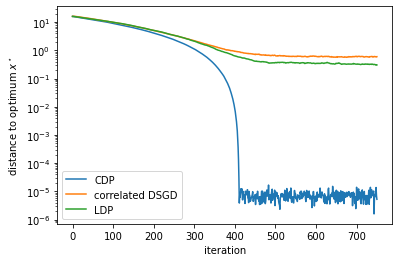

In [7]:
plt.semilogy(errors_centr, label="CDP")
plt.semilogy(errors_cor, label="correlated DSGD")
plt.semilogy(errors_ldp, label="LDP")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("distance to optimum $x^\star$")

No handles with labels found to put in legend.


Text(0, 0.5, '$\\varepsilon$')

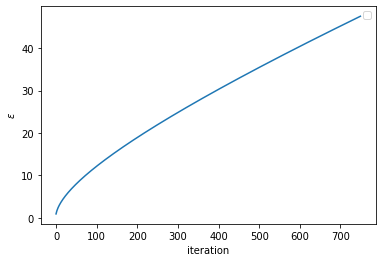

In [8]:
delta = 1 / (num_nodes ** 1.1)
eps = [rdp_compose_convert(i, eps_rdp_iteration, delta) for i in range(1, num_iter+1)]
plt.plot(eps)
plt.legend()
plt.xlabel("iteration")
plt.ylabel("$\\varepsilon$")

In [9]:
# plt.semilogy(errors_centr, label="CDP")
# plt.semilogy(errors_cor, label="correlated DSGD")
# plt.semilogy(errors_ldp, label="LDP")
# plt.legend()
# plt.xlabel("iteration")
# plt.ylabel("distance to optimum $x^\star$")

In [10]:
# X = np.ones(shape=(num_dim, num_nodes))
# W_ring = FixedMixingMatrix("centralized", num_nodes)

In [11]:
# errors, _ = optimize_decentralized_correlated(X, W_ring, A, B, gamma, sigma, sigma_cor, num_iter=num_iter)

In [12]:
# X = np.ones(shape=(num_dim, num_nodes))
# W_ring = FixedMixingMatrix("centralized", num_nodes)

In [13]:
# errors_uncorr, _ = optimize_decentralized_correlated(X, W_ring, A, B, gamma, sigma, sigma_cor, num_iter=num_iter, uncorrelate=True)

In [14]:
# plt.semilogy(errors_uncorr, label="uncorr")
# plt.semilogy(errors, label="corr")
# plt.legend()

In [15]:
def test_ratio_n(n):
    out = {}
    topos = ['ring', 'avg_two_ring']

    for top in topos:
        out_top = []

        for k in range(2, n):
            W = FixedMixingMatrix(top, 2 * k)(0)
            mixing_heterogeneity = sum([0.5 * np.linalg.norm(W[:, i] - W[:, j], 2) ** 2 for i in range(k)
                                    for j in range(k) if W[i, j] != 0])
            naive_bound = sum([1 for i in range(k)
                                    for j in range(k) if W[i, j] != 0])
            ratio = mixing_heterogeneity / naive_bound
            # ratio = naive_bound / mixing_heterogeneity
            out_top.append(1 / (1-ratio))
            # out_top.append(mixing_heterogeneity)
        out[top] = out_top

    for top in topos:
        # plt.yscale('log')
        plt.plot([2 * k for k in range(2, n)], out[top], label=top)

    plt.legend()

def test_ratio_tau(tau, n=10):
    out = {}
    topos = ['ring', 'avg_two_ring']

    for top in topos:
        out_top = []

        for t in range(1, tau):
            W = FixedMixingMatrix(top, n)(0) ** t
            mixing_heterogeneity = sum([0.5 * np.linalg.norm(W[:, i] - W[:, j], 2) ** 2 for i in range(n)
                                    for j in range(n) if W[i, j] != 0])
            naive_bound = sum([1 for i in range(n)
                                    for j in range(n) if W[i, j] != 0])
            ratio = mixing_heterogeneity / naive_bound
            # ratio = naive_bound / mixing_heterogeneity
            out_top.append(ratio)
            # out_top.append(mixing_heterogeneity)
        out[top] = out_top

    for top in topos:
        plt.yscale('log')
        plt.plot(range(1, tau), out[top], label=top)

    plt.legend()

# test_ratio_tau(100)
# test_ratio_n(200)

In [16]:
# errors_uncorr, _ = optimize_decentralized_correlated(X, W_ring, A, B, gamma, sigma, sigma_cor, num_iter=num_iter, uncorrelate=True)